# Introductory Machine Learning: Assignment 2

**Deadline:**

Assignment 2 is due Thursday, February 19 at 11:59pm. Late work will not be accepted as per the course policies (see the syllabus on [Canvas](https://canvas.yale.edu)).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas.  You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission:**

Submit your assignment as a .pdf on Gradescope. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. **Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to find your complete solution to each problem.**

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds265-sp26/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).


**Topics**
1. Logistic regression
2. Regularization
3. Stochastic gradient descent
4. Trees
5. Bias-variance tradeoff

## Problem 1: Penguins: An ice example (20 points)

Can you tell one penguin species from another? Let's put what we've learned about logistic regression to (a very cute) test!

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins_ds_species.png" width="500" align="center" style="margin:10px 30px 10px 0px">

We first need to learn a little about the anatomy of our flightless feathered friends. The *culmen* is the upper ridge of a bird’s bill.

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins_ds_culmen.png" width="500" align="center" style="margin:10px 30px 10px 0px">

In our dataset, the culmen length and depth are called `bill_length_mm` and `bill_depth_mm`.

*Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station, Antarctica LTER](https://pallter.marine.rutgers.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/). Artwork by @allison_horst.


In [287]:
# run this cell to import needed packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [288]:
# just run this cell to read in the data, and drop a couple variables

df = pd.read_csv('https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins.csv')
df = df.drop(columns=['index','year','island'])
df = df.dropna(axis=0)
df



,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,male
1,Adelie,39.5,17.4,186.0,3800.0,female
2,Adelie,40.3,18.0,195.0,3250.0,female
4,Adelie,36.7,19.3,193.0,3450.0,female
5,Adelie,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,male
340,Chinstrap,43.5,18.1,202.0,3400.0,female
341,Chinstrap,49.6,18.2,193.0,3775.0,male
342,Chinstrap,50.8,19.0,210.0,4100.0,male


In [289]:
# Next we'll make the sex variable binary, and separate out
# species as the label to predict

species = list(set(df['species']))
df['class'] = LabelEncoder().fit_transform(df['species'])
sex = [int(list(df['sex'])[j]=='male') for j in range(len(df))]
df['sex'] = sex
df = df.drop(columns=['species'])
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,class
0,39.1,18.7,181.0,3750.0,1,0
1,39.5,17.4,186.0,3800.0,0,0
2,40.3,18.0,195.0,3250.0,0,0
4,36.7,19.3,193.0,3450.0,0,0
5,39.3,20.6,190.0,3650.0,1,0
...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1,1
340,43.5,18.1,202.0,3400.0,0,1
341,49.6,18.2,193.0,3775.0,1,1
342,50.8,19.0,210.0,4100.0,1,1


### 1.1 Plotting the data

The following cell shows a scatter plot of all pairs of variables. We showed this type of plot in class for the California housing data.
Describe several entries in this plot, and what it tells you about the
the relationship between the pairs of covariates. Do the relationships make intuitive sense? Why or why not? Do the data appear to have any obvious outliers or unusual patterns? Why or why not?


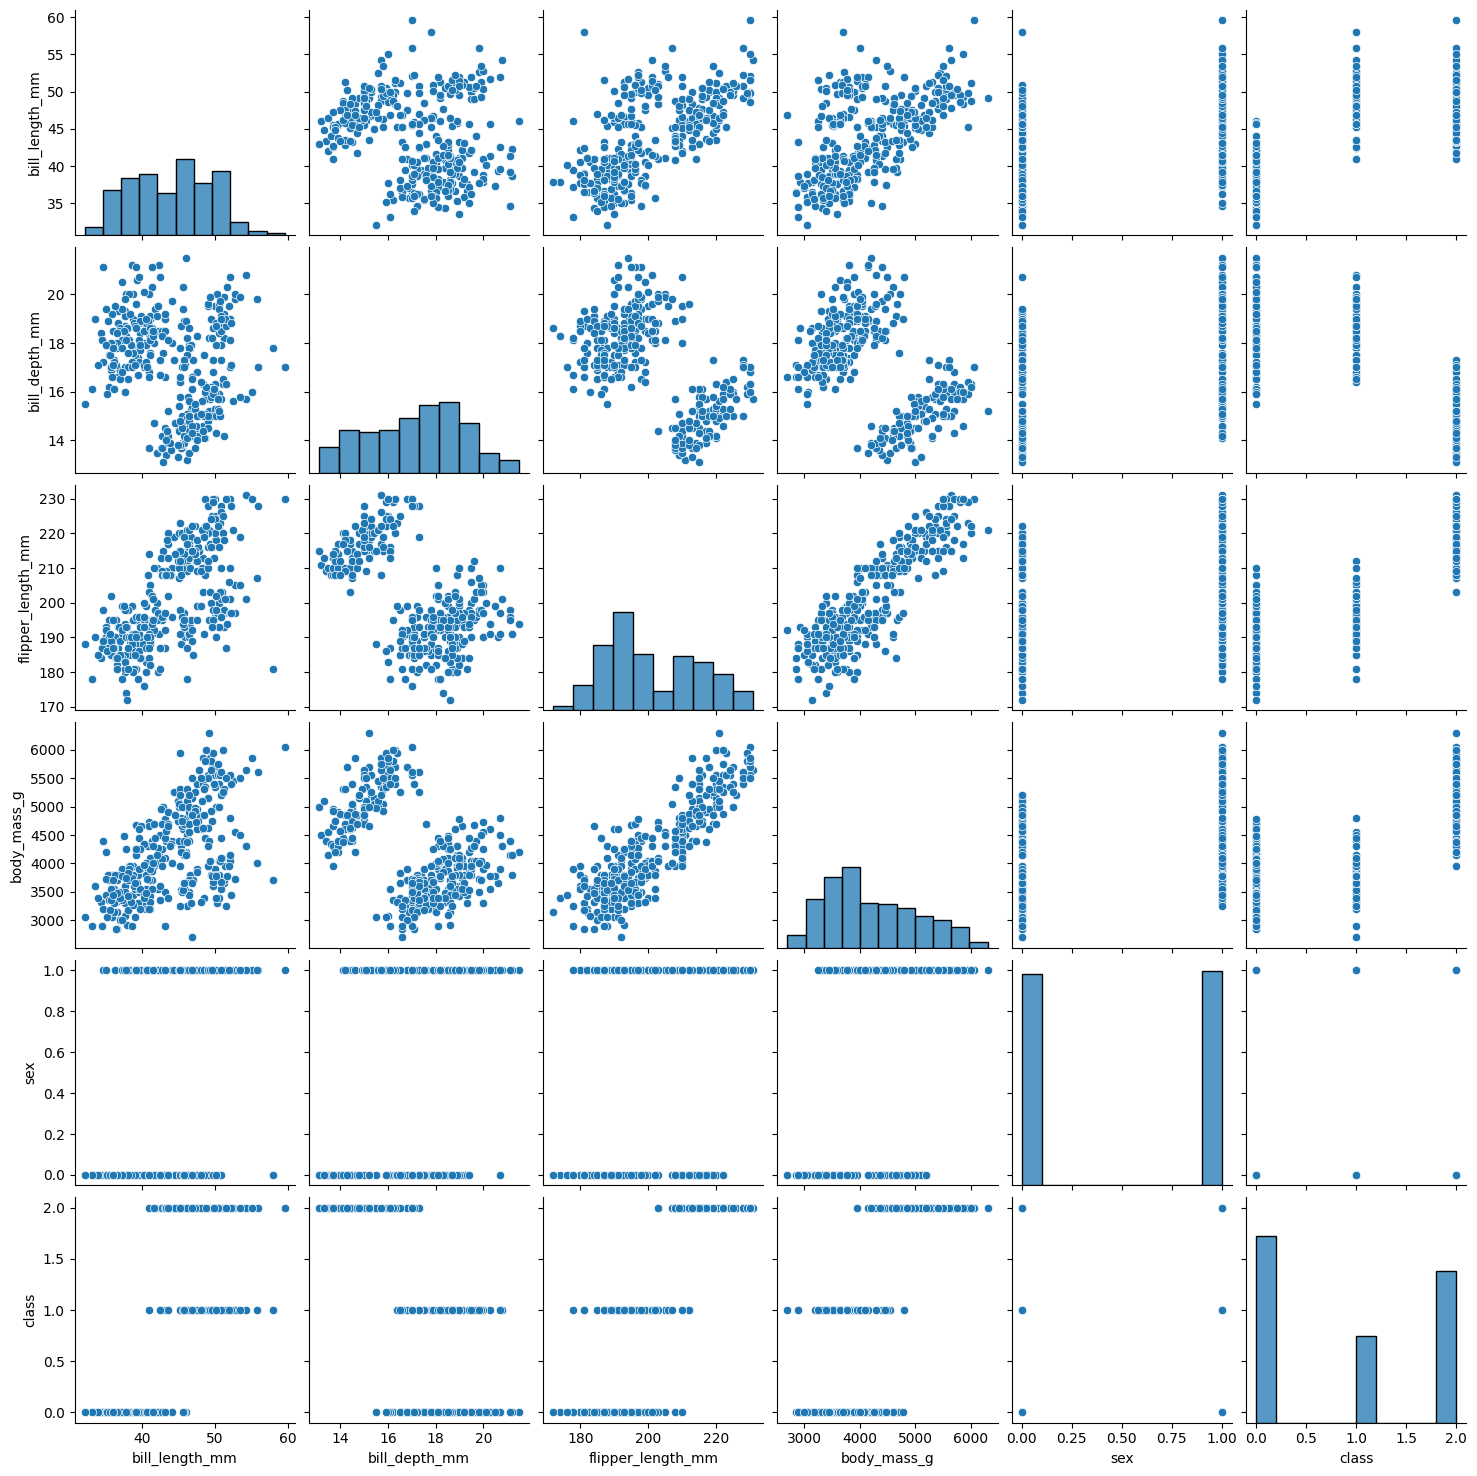

In [290]:
_ = sns.pairplot(df)

The pairwise scatter plot shows strong relationships among the continuous morphology variables. Flipper length and body mass exhibit a clear positive association, indicating that larger penguins tend to be heavier, which is intuitive given overall body size. Bill length also tends to increase with flipper length and body mass, suggesting that multiple size-related measurements scale together. In contrast, bill length versus bill depth does not follow a single linear trend and instead appears clustered, which plausibly reflects different groups (e.g., different classes/species) with distinct bill shapes rather than a simple size effect. Plots involving the discrete variables (sex and class) form horizontal/vertical bands because these variables take only a few distinct values. Overall, there are no obvious extreme outliers; most points fall within plausible ranges, and the most notable “unusual” pattern is the presence of clusters and banding, consistent with mixture structure and categorical covariates rather than data errors.

In [291]:
def plot_features(df, feature1_name, feature2_name):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    colors = ['orange', 'pink', 'lightgreen']
    species = ['Adelie', 'Chinstrap', 'Gentoo']

    for c in range(3):
        mask = (df['class']==c)
        plt.scatter(df[feature1_name][mask],
                    df[feature2_name][mask],
                    color=colors[c], label=species[c])

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.legend(loc='upper left')
    plt.show()



### 1.1 Plotting the data (continued)

Next, using the `plot_features` function above,
give additional plots of pairs of features, shown together with
the class labels. An example of such a plot is shown below:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/feature_plot.jpg" width="500" align="center" style="margin:10px 30px 10px 0px">

For each plot, discuss why the pair of features may or not be helpful in discriminating between the three species of penguins.

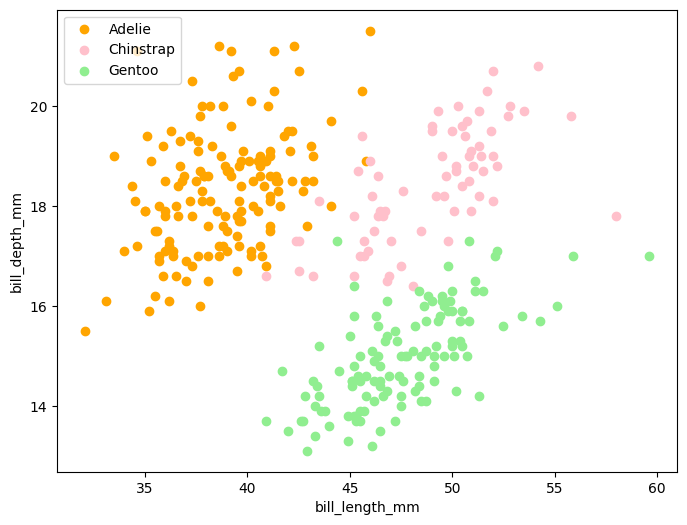

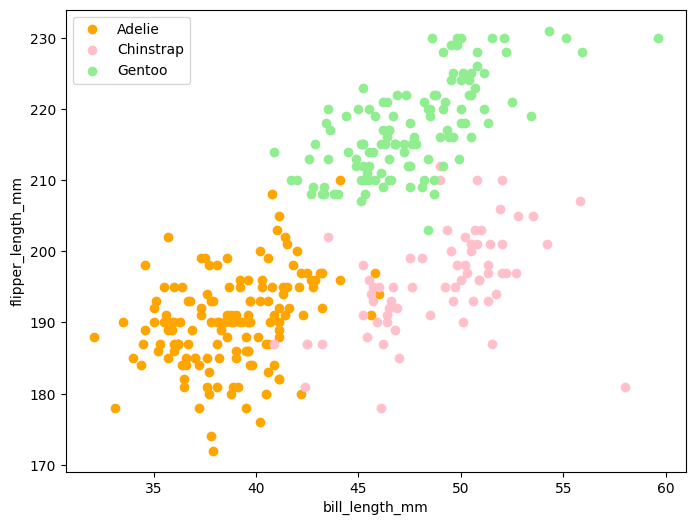

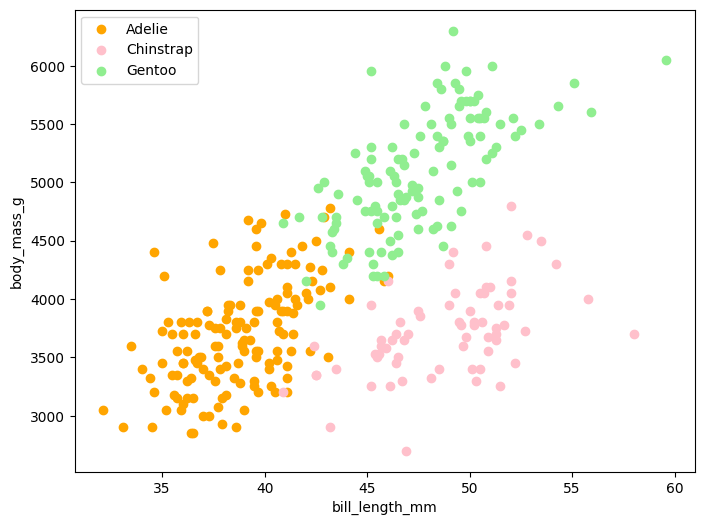

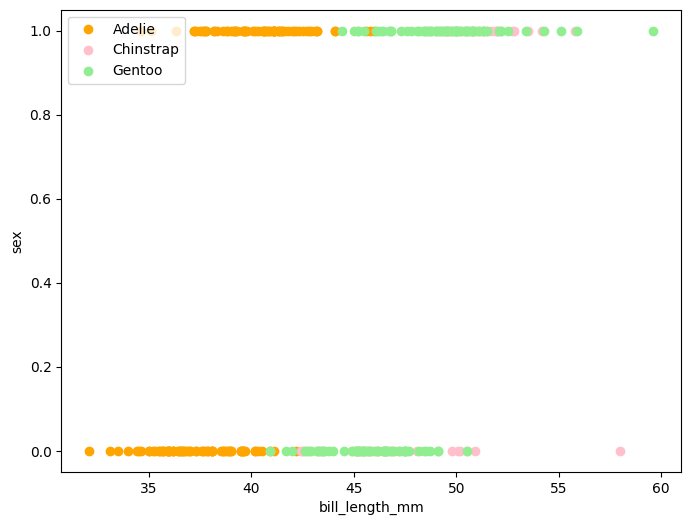

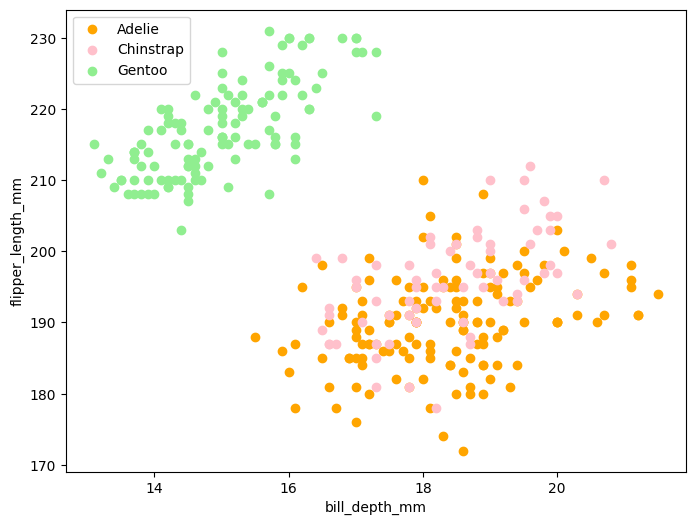

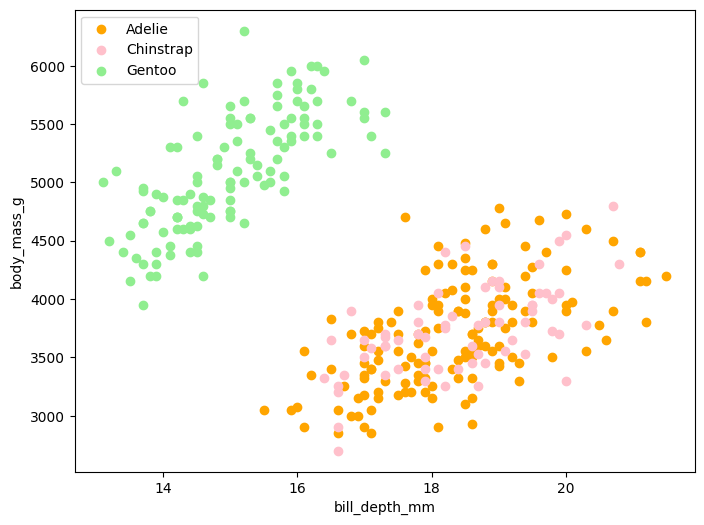

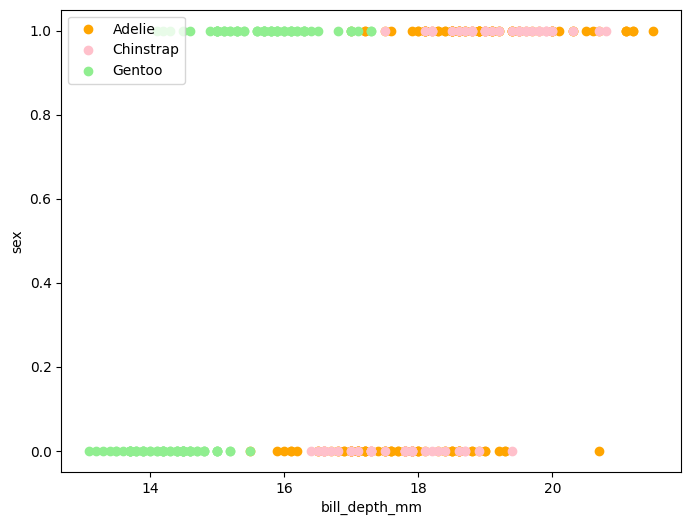

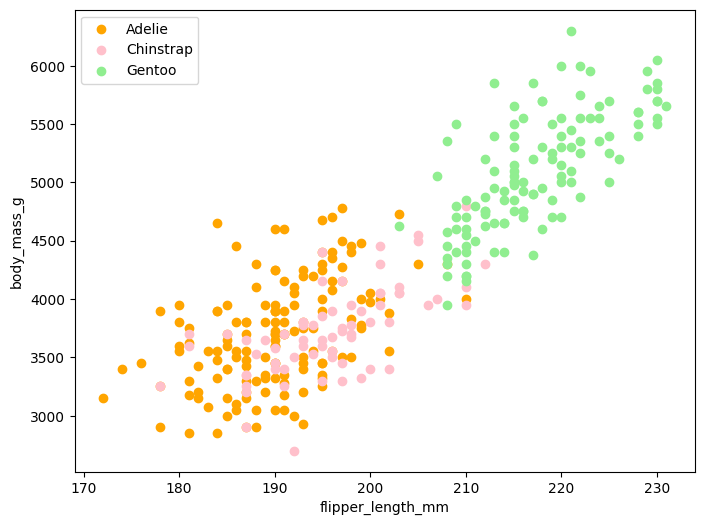

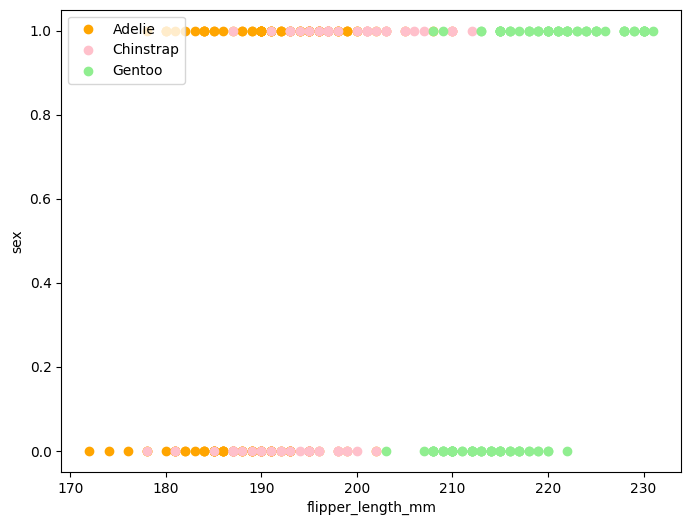

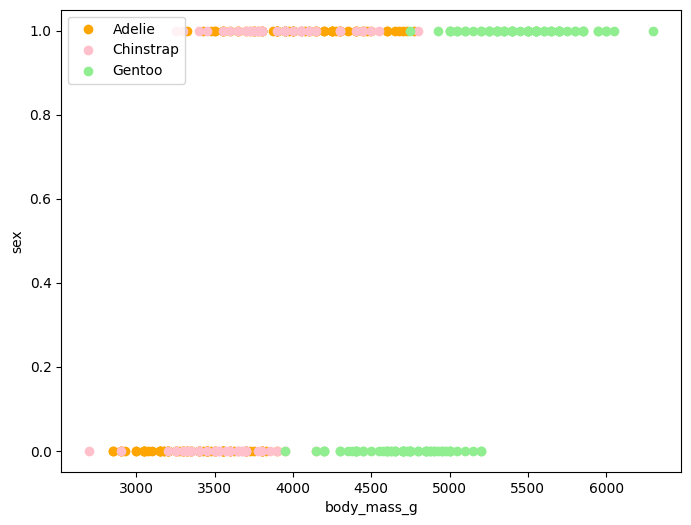

In [292]:
# your code and markdown here
columns = df.columns
columns = columns.drop('class')
for i in range(len(columns)):
  for j in range(i+1,len(columns)):
    plot_features(df, columns[i], columns[j])

- **bill_length_mm vs bill_depth_mm**  
  This pair shows clear clustering: *Gentoo* tends to have **shallower bills** (lower depth), while *Chinstrap* tends to have **longer bills**. *Adelie* overlaps with *Chinstrap* in depth but generally has shorter bills, so the separation is decent but not perfect.

- **bill_length_mm vs flipper_length_mm**  
  This is highly informative. *Gentoo* forms a distinct cluster with **much longer flippers**, and *Chinstrap* typically has **longer bills** than *Adelie*. Most confusion happens where *Adelie* and *Chinstrap* overlap around mid flipper lengths.

- **bill_length_mm vs body_mass_g**  
  Also quite helpful: *Gentoo* is typically **heavier**, so it separates well from the other two. *Adelie* and *Chinstrap* overlap in mass, but bill length helps somewhat (Chinstrap tends to have longer bills).

- **bill_length_mm vs sex**  
  Not very helpful for species separation. Since `sex` is binary, points form two horizontal bands, and each band contains all three species with substantial overlap.

- **bill_depth_mm vs flipper_length_mm**  
  Useful mainly for isolating *Gentoo*: it tends to have **longer flippers** and **smaller bill depth**, giving a clear cluster. *Adelie* and *Chinstrap* overlap heavily in this projection.

- **bill_depth_mm vs body_mass_g**  
  Moderately helpful: *Gentoo* again separates due to **higher mass** and **lower bill depth**. *Adelie* and *Chinstrap* remain mixed because they share similar bill depths and masses.

- **bill_depth_mm vs sex**  
  Not very useful. The binary `sex` variable creates banding, and bill depth alone does not cleanly separate *Adelie* vs *Chinstrap* across sexes.

- **flipper_length_mm vs body_mass_g**  
  Very helpful for separating *Gentoo*: it has **both longer flippers and higher body mass**. However, *Adelie* and *Chinstrap* overlap in this space, so this pair mainly distinguishes Gentoo from the others.

- **flipper_length_mm vs sex**  
  Weak for species discrimination. While flipper length varies by species, the `sex` axis adds little separation because both sexes appear across species, producing overlap within each band.

- **body_mass_g vs sex**  
  Not very helpful for identifying species. Even if mass differs somewhat across species, using `sex` as the second axis does not create clear class-separated regions; there is still substantial overlap within each sex band.

In [293]:
# Just run the following cell, to get inputs X and labels y
y = np.array(df['class'])
X = df.copy()
X = X.drop(columns=['class'])
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1
340,43.5,18.1,202.0,3400.0,0
341,49.6,18.2,193.0,3775.0,1
342,50.8,19.0,210.0,4100.0,1


### 1.2 Standardize the data

Next, standardize the data, so that each column of `X` has
mean zero and standard deviation one. Note that after you have done this transformation, `X` should still be a `pandas.DataFrame`. Then, briefly explain why it is important to standardize the variables in the logistic regression models that you will train below.

In [294]:
# Your code here
for column in X.columns:
  data = X[column]
  mu = data.mean()
  sd = data.std()
  X[column] = (data-mu)/sd



Standardization is important for logistic regression because the predictors are on very different scales (e.g., body mass is in thousands while bill measurements are in tens); without scaling, large-magnitude features can dominate the optimization and make the fitted coefficients hard to compare. Putting all features on the same scale typically improves numerical stability and convergence of gradient-based solvers, and it ensures that regularization (if used) penalizes coefficients fairly across predictors rather than disproportionately shrinking those measured in smaller units.


### 1.3 Fit logistic regressions

As done in the class demo for mushrooms and iris flowers, you will now  construct a series of logistic regression models using an increasing number of training points.

Specifically, we want you to:

* Vary the sample size from 10% of the data to 90% of the data, in increments of 10%
* For each sample size, train a logistic regression model on randomly selected training points, and test on the remaining data
* For each sample size, run 100 trials and average the error rates
* Plot the resulting average error rates as a function of sample percentage of the data

We will use the function sklearn.model_selection.train_test_split in each trial to randomly split the data into training and test sets.

Here we repeat exactly what we did during class using `lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')` to fit a logistic regression model to predict the three species  (*Adelie*, *Chinstrap*, and *Gentoo*).

After filling in your code, simply run this cell to plot a learning curve of error rate as a function of training percentage.


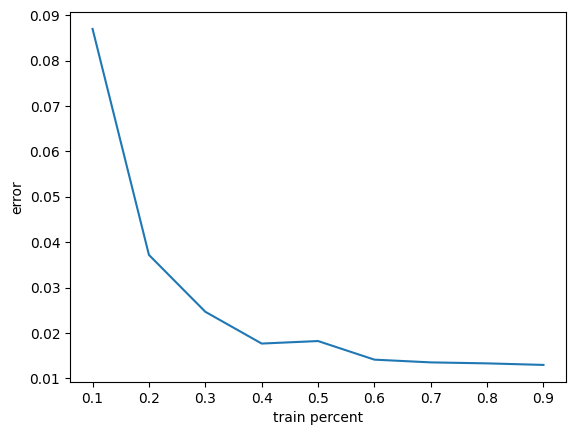

In [295]:
lr = LogisticRegression(penalty='l2', C=.1, solver='lbfgs')

lr_error_rate = []
trials = 100
train_percent = np.linspace(.1, .9, 9)

# For each training set percentage, create train/test split accordingly
# and run logistic regression 100 times and calculate the average error rate

"""
function input:
  X: data
  y: label
  ratio: train data percentage
  trails: number of trails to run

function return:
  the average error rate with this train data percentage
"""

def get_err_rate(X, y, ratio, trials):
    # todo:
    # your code starts here
    err = []
    for i in range(trials):
      X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=ratio)
      lr.fit(X_train,y_train)
      test_err = np.mean(lr.predict(X_test)!=y_test)
      err.append(test_err)
    return np.mean(err)

    # your code ends here

# Use get_err_rate to find the error rate for respective split size
for p in train_percent:
    lr_error_rate.append(get_err_rate(X, y, p, trials))


plt.plot(train_percent, lr_error_rate)
plt.xlabel('train percent')
plt.ylabel('error')
plt.show()

### 1.4 Choose good feature pairs

Which pair of variables gives the best predictions of the species of penguins? Run some experiments and report back below!

Note that there are ${5 \choose 2} = 10$ ways you can choose a pair of features. You may want to run a loop to automate this. And choose a reasonable `ratio` from the stable region of plot 1.3, such as 0.7 :)




In [296]:
# todo:
# your code starts here
err_rate = {}
for i in range(len(columns)):
  for j in range(i+1,len(columns)):
    err_rate[(columns[i],columns[j])]=get_err_rate(X[[columns[i],columns[j]]], y, 0.9, trials)

min_key = min(err_rate, key=err_rate.get)
print('The pair of variables that gives the best predictions of the species of penguins is', min_key)
# your code ends here

The pair of variables that gives the best predictions of the species of penguins is ('bill_length_mm', 'flipper_length_mm')


### 1.5 Visualize the decision boundries

Using the two features you chose as the best, and at least two additional
pairs of features, visualize the decision boundries of the logistic regression models.

Is it what you expected? Where are you observing incorrect predictions? Describe why the decision boundaries make sense, from your understanding of the logistic regression model.

Use the function `plot_decision_boundaries` that we supply below. (You may also modify this function to your liking.) An example plot is shown here:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/sample_decision_boundaries.jpg" width="400" align="center" style="margin:10px 30px 10px 0px">


In [297]:
def plot_decision_boundaries(X, y, model, error):
    X2 = np.array(X)
    b = model.intercept_
    beta = model.coef_.T
    colors = ['orange', 'pink', 'lightgreen']
    h = 0.015
    x_min, x_max = X2[:, 0].min() - .5, X2[:, 0].max() + .5
    y_min, y_max = X2[:, 1].min() - .5, X2[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], beta) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, levels=[0,.5,1.5,2.5], colors=colors, alpha=0.5)
    for c in range(3):
        mask = (y==c)
        plt.scatter(X2[np.array(mask),0], X2[np.array(mask),1], color=colors[c], label=species[c])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='upper left')
    plt.title('error rate: %.2f' % error)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])


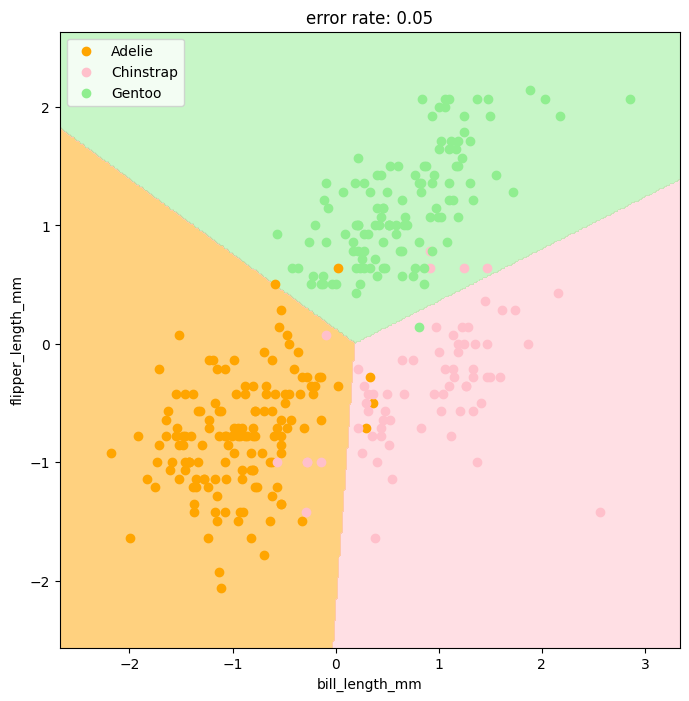

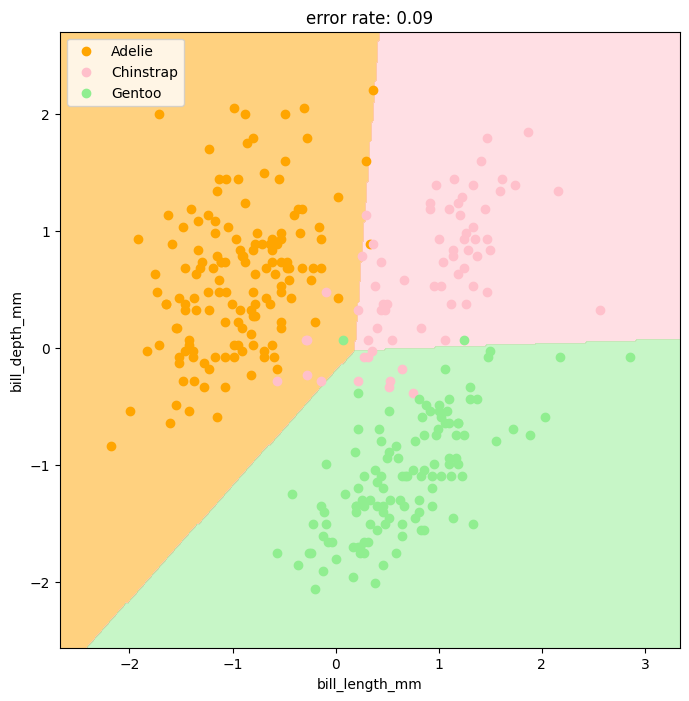

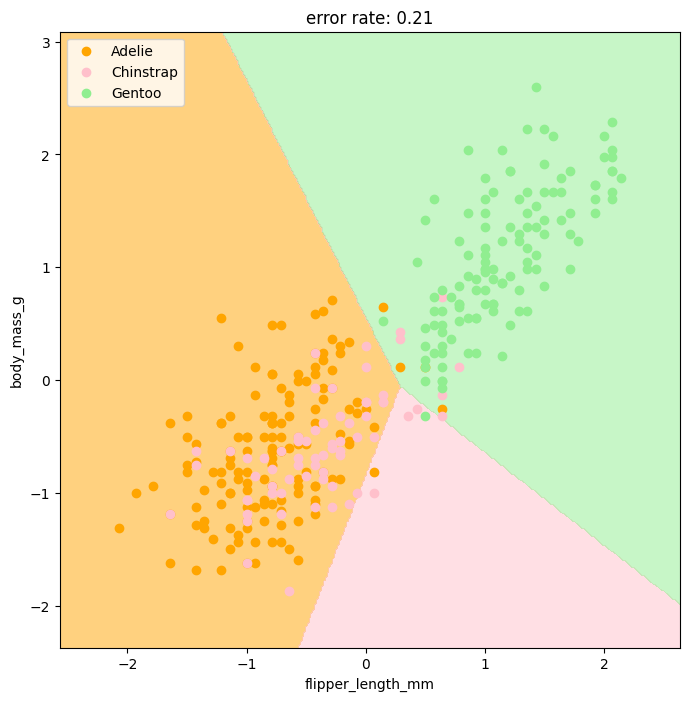

In [298]:
# Your code and markdown here
X_best = X[[min_key[0], min_key[1]]]

lr_plot = lr
lr_plot.fit(X_best, y)

plot_decision_boundaries(X_best, y, lr_plot, err_rate[min_key])

extra_pairs = [
    ['bill_length_mm', 'bill_depth_mm'],
    ['flipper_length_mm', 'body_mass_g']
]

for pair in extra_pairs:
    X_pair = X[pair]

    lr_pair = LogisticRegression(penalty='l2', C=.1, solver='lbfgs', max_iter=1000)
    lr_pair.fit(X_pair, y)

    X_train, X_test, y_train, y_test = train_test_split(X_pair, y, train_size=0.9, stratify=y, random_state=0)
    lr_tmp = LogisticRegression(penalty='l2', C=.1, solver='lbfgs', max_iter=1000)
    lr_tmp.fit(X_train, y_train)
    err = np.mean(lr_tmp.predict(X_test) != y_test)

    plot_decision_boundaries(X_pair, y, lr_pair, err)


I visualize the multinomial logistic regression decision boundaries. Overall, the shapes are expected: with two (standardized) features, multinomial logistic regression produces **piecewise-linear** decision regions, since the predicted class is  
$$
\arg\max_k \; (\beta_k^\top x + b_k),
$$
so the boundaries between classes are linear in the 2D feature space.

- **Best pair: (bill_length_mm, flipper_length_mm)** *(error rate ≈ 0.05)*  
  This pair separates the three species well: Adelie tends to have smaller values, Gentoo tends to have larger flippers, and Chinstrap is mostly distinguished by larger bill length but smaller flippers than Gentoo. Most mistakes occur near the borders where Chinstrap overlaps with Adelie or where a few points lie close to the Gentoo/Chinstrap boundary.

- **Additional pair 1: (bill_length_mm, bill_depth_mm)** *(error rate ≈ 0.09)*  
  The decision regions are still linear, but **Adelie and Chinstrap overlap more** in this projection (similar bill depth ranges), so misclassifications concentrate around their shared boundary. Gentoo remains relatively separable due to its distinct bill depth/length pattern.

- **Additional pair 2: (flipper_length_mm, body_mass_g)** *(error rate ≈ 0.21)*  
  This pair strongly separates **Gentoo** (larger/heavier), but Adelie vs. Chinstrap overlap substantially in overall size, so many points near the middle region are misclassified. The higher error rate is consistent with the visible class overlap in this 2D view.

In all three plots, incorrect predictions mainly occur where the classes overlap in the chosen 2D feature space; since the model is linear in these two features, it cannot perfectly separate classes when their measurements are not linearly separable.


### 1.6 (Optional) Use different regularization levels (2 points EC)

Now that you have a working logistic regression algorithm, explore how to set the regularization level $C=1/\lambda$. Use an appropriate cross-validation procedure to choose the regularization level, and explain your results.

100%|██████████| 99/99 [00:11<00:00,  8.72it/s]


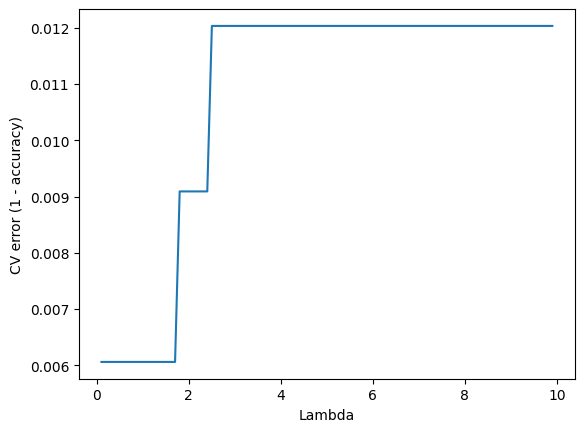

Best lambda: 0.1   Best CV error: 0.0060606060606061


In [299]:
# Your code and markdown here
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

Lambda = np.arange(0.1,10,0.1)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

cv_error = []
for lam in tqdm(Lambda):
    model = LogisticRegression(penalty="l2",C=1/lam,solver="lbfgs")
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    cv_error.append(1 - acc.mean())

plt.plot(Lambda, cv_error)
plt.xlabel("Lambda")
plt.ylabel("CV error (1 - accuracy)")
plt.show()

best_lam = Lambda[np.argmin(cv_error)]
print("Best lambda:", best_lam, "  Best CV error:", min(cv_error))


In the experiment, the \textbf{best} regularization level was $\lambda = 0.1$ (the largest $C$ in our grid),
with a \textbf{minimum CV error} of approximately $0.0061$.
As $\lambda$ increased (stronger regularization), the CV error increased and then plateaued.
This suggests that, for this dataset, logistic regression using the standardized features already generalizes well with relatively weak regularization;
increasing $\lambda$ primarily shrinks coefficients and adds bias without a compensating reduction in variance.

Hooray! You are now a penguin master!

## Problem 2: Mini-Batch Gradient Descent (25 points)

Consider a univariate logistic regression where we are trying to predict $Y$, which can take the value $0$ or $1$, from the variable $X$, which takes real values. Recall from lecture that we need to estimate parameters $\beta_{0}$ and $\beta_{1}$ by minimizing the penalized loss function:

$L(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left[ log\left( 1 + e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\left(\beta_{0} + X_{i}\beta_{1}\right)\right] + \lambda \beta_{1}^{2}$ .

Note that generally the intercept is not penalized.

In this problem, we will implement mini-batch gradient descent. At each iteration, a random set of $m$ samples from all $n$ samples is used to calculate the loss and gradient, which is the change in the loss with respect to the parameters. We then update the estimates of $\beta_{0}$ and $\beta_{1}$ based on the gradient.

Run the next cell to simulate data using the parameter values of $\beta_{0} = 3$ and $\beta_{1} = -5$.

In [300]:
n = 10000
np.random.seed(265)
x1 = np.random.uniform(-5, 5, size=n)
beta0 = 3
beta1 = -5
p = np.exp(beta0 + x1*beta1)/(1 + np.exp(beta0 + beta1*x1))
y = np.random.binomial(1, p, size=n)


Here is a helper function for plotting we'll use later. Just run this cell; don't change it.

In [301]:
def plot_betas_and_loss(beta0_all, beta1_all, loss_all, title=''):
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    ax[0].plot(np.arange(len(beta0_all)), beta0_all)
    ax[0].hlines(beta0, xmin=0, xmax=len(beta0_all),color = 'r')
    ax[0].set_xlabel("Iteration", fontsize=12)
    ax[0].set_ylabel(r"$\widehat{\beta}_{0}$", fontsize=12)

    ax[1].plot(np.arange(len(beta1_all)), beta1_all)
    ax[1].hlines(beta1, xmin=0, xmax=len(beta1_all),color = 'r')
    ax[1].set_xlabel("Iteration", fontsize=12)
    ax[1].set_ylabel(r"$\widehat{\beta}_{1}$", fontsize=12)
    ax[1].set_title(title)

    ax[2].plot(np.arange(len(loss_all)), loss_all)
    ax[2].set_xlabel("Iteration", fontsize=12)
    ax[2].set_ylabel("Loss", fontsize=12)
    plt.show()

### 2.1 Deriving the updates

Let $L_{t}(\beta_{0}, \beta_{1})$ be the loss at $t$-th iteration.
For given values of $\beta_{0}$ and $\beta_{1}$, the vector $\left( \dfrac{\partial}{\partial \beta_{0}} L_{t}(\beta_{0}, \beta_{1}), \dfrac{\partial}{\partial \beta_{1}} L_{t}(\beta_{0}, \beta_{1}) \right)^{T}$ is called the gradient of $L_{t}(\beta_{0}, \beta_{1})$ and is denoted $\nabla L_{t}(\beta_{0}, \beta_{1})$.

We calculate the derivative of $L_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{0}$, treating $\beta_{1}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{0}} L_{t}(\beta_{0}, \beta_{1})$):

$\dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left(\dfrac{e^{\beta_{0} + X_{i}\beta_{1}}}{1+e^{\beta_{0} + X_{i}\beta_{1}}}- Y_{i}\right)$.



Now calculate the derivative of $L_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{1}$, treating $\beta_{0}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{1}} L_{t}(\beta_{0}, \beta_{1})$).

Be sure to show your work by either typing it in here using LaTeX, or by taking a picture of your handwritten solutions and displaying them here in the notebook. (If you choose the latter of these two options, be sure that the display is large enough and legible. Please also upload a photo seperately to Gradescope in case the embedded image failed.)

**[put your solution here]**
$$
L(\beta_0,\beta_1)=\frac{1}{n}\sum_{i=1}^n\left[\log\left(1+e^{\beta_0+X_i\beta_1}\right)-Y_i(\beta_0+X_i\beta_1)\right]+\lambda \beta_1^2
$$

Let
$$
\qquad Z_i=\beta_0+X_i\beta_1,\qquad \sigma(Z)=\frac{1}{1+e^{-Z}}.
$$

We have
$$
\frac{\partial}{\partial Z_i}\log\left(1+e^{Z_i}\right)=\frac{e^{Z_i}}{1+e^{Z_i}}=\sigma(Z_i),
\qquad \frac{\partial Z_i}{\partial \beta_1}=X_i.
$$

$$
\frac{\partial}{\partial \beta_1}\left[\log\left(1+e^{Z_i}\right)-Y_i Z_i\right]
=\sigma(Z_i)\,X_i-Y_i X_i
=X_i\left(\sigma(Z_i)-Y_i\right).
$$

$$
\frac{\partial}{\partial \beta_1}\left(\lambda \beta_1^2\right)=2\lambda\beta_1.
$$

$$
\frac{\partial L}{\partial \beta_1}
=\frac{1}{n}\sum_{i=1}^n X_i\left(\sigma(\beta_0+X_i\beta_1)-Y_i\right)+2\lambda\beta_1
$$

Finally we get:
$$
\boxed{
\frac{\partial L}{\partial \beta_1}
=\frac{1}{n}\sum_{i=1}^n X_i\left(\frac{e^{\beta_0+X_i\beta_1}}{1+e^{\beta_0+X_i\beta_1}}-Y_i\right)+2\lambda\beta_1
}
$$



When we implement mini-batch stochastic gradient descent, we will use these formulas, but
apply them to a mini-batch of $m$ randomly chosen datapoints, rather than to all $n$ datapoints
(in our case $n=10,000$).
Typically $m$ is chosen to be much, much smaller than $n$.




### 2.2 The key ingredients

Complete the function `update` in the following cell which takes values for $\beta_{0}$ and $\beta_{1}$, a list `inds`  containing the indexes of the $m$ selected samples, as well as a step-size $\eta$, and returns updated values for $\beta_{0}$ and $\beta_{1}$ from one step of gradient descent (using all the data and your answer to Part a).

In [302]:
def update(b0, b1, inds, step_size, lamb):

    m = len(inds)
    x_inds = x1[inds]
    y_inds = y[inds]
    yh = b0+b1*x_inds
    logi = 1/(1+np.exp(-yh))

    L_partial0 = 1/m*np.sum(logi-y_inds)
    L_partial1 = 1/m*np.sum(x_inds*(logi-y_inds))+2*lamb*b1

    b0 -= step_size * L_partial0
    b1 -= step_size * L_partial1
    return (b0, b1)

Now complete the function in the next cell called `loss` which takes values for $\beta_{0}$ and $\beta_{1}$,
together with a subset of indices and regularization parameter, and returns the value of the loss function evaluated at those data points.

In [303]:
def loss(b0, b1, inds, lamb):

    m = len(inds)
    x_inds = x1[inds]
    y_inds = y[inds]
    yh = b0+b1*x_inds


    output = 1/m*np.sum(np.log(1+np.exp(yh))-y_inds*yh)+lamb*b1**2

    return output

### 2.3 Putting it all together

Now complete the implementation of `minibatch_grad_descent` which puts all of these pieces together

In [304]:
def minibatch_grad_descent(b0=0, b1=0, batch_size=100, step_size=10, lamb=0, iterations=1000):
    beta0_hat = b0
    beta1_hat = b1
    beta0_all = []
    beta1_all = []
    loss_all = []


    for iter in range(iterations):
        inds = np.random.choice(10000, size=batch_size, replace=False)
        batch_loss = loss(beta0_hat,beta1_hat,inds,lamb)
        beta0_hat, beta1_hat = update(beta0_hat,beta1_hat,inds,step_size,lamb)

        beta0_all.append(beta0_hat)
        beta1_all.append(beta1_hat)
        loss_all.append(batch_loss)

    return (beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all)

Now, test your implementation by running the following cell, which will call the function
with the default parameters, and then plot the beta parameters and loss during the course
of stochastic gradient descent. We will check your plot as a first check that you have a correct implementation! You should expect the first plot looks like the following:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/mini_batch_gd.png" width="400" align="center" style="margin:10px 30px 10px 0px">

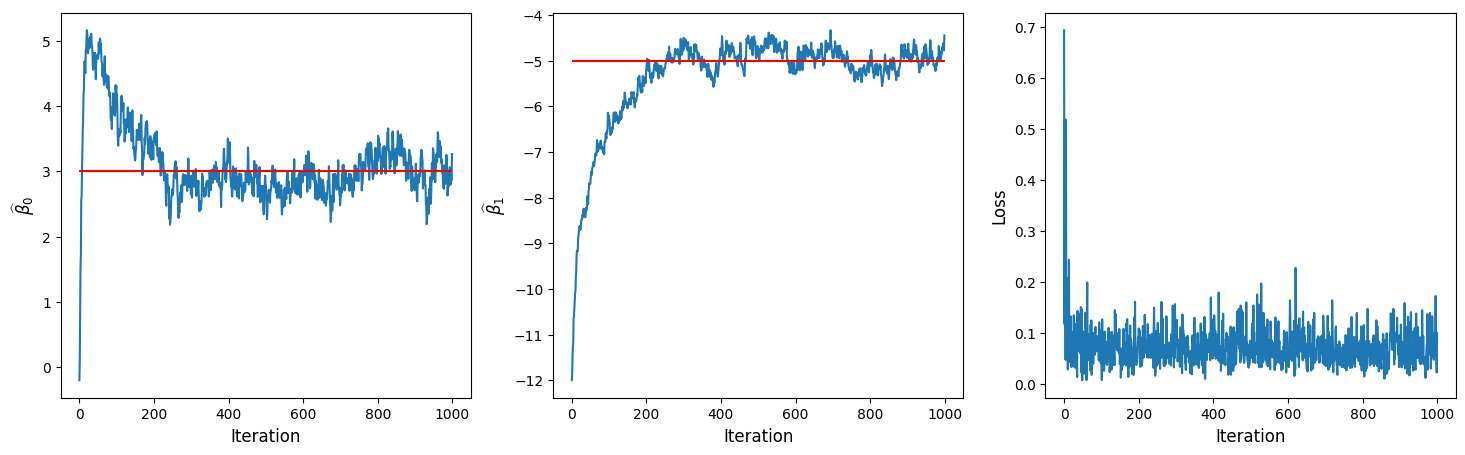

In [305]:
# Run this cell, don't change it!

beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all = minibatch_grad_descent()
plot_betas_and_loss(beta0_all, beta1_all, loss_all)


### 2.4 Assessing uncertainty

We now use the code above that implements mini-batch gradient descent and
run it several (30) times. We then display the mean and standard deviation of
the estimates.


In [306]:
# run this cell, don't change it

from tqdm import tqdm

beta0_hat_all_0 = []
beta1_hat_all_0 = []
for rep in tqdm(range(30)):
    beta0_hat, beta1_hat, _, _, _ = minibatch_grad_descent()
    beta0_hat_all_0.append(beta0_hat)
    beta1_hat_all_0.append(beta1_hat)

print('The mean of the estimated beta0 is %.2f' % np.mean(beta0_hat_all_0))
print('The standard deviation of the estimated beta0 is %.3f' % np.std(beta0_hat_all_0))
print('The mean of the estimated beta1 is %.2f' % np.mean(beta1_hat_all_0))
print('The standard deviation of the estimated beta1 is %.3f' % np.std(beta1_hat_all_0))

100%|██████████| 30/30 [00:08<00:00,  3.69it/s]

The mean of the estimated beta0 is 2.82
The standard deviation of the estimated beta0 is 0.255
The mean of the estimated beta1 is -4.83
The standard deviation of the estimated beta1 is 0.228


Comment on these results:

1. Describe what causes the variation in the estimates.
1. How would you construct approximate 95% confidence intervals for the estimates?
1. Do the true parameters fall in those confidence intervals?

**[Put your answers in this markdown cell]**

The estimates vary across the 30 repetitions mainly because each run uses random mini-batches (and potentially different random initializations), so the stochastic gradients are noisy and the algorithm converges to slightly different solutions. Finite-sample randomness in the simulated data also contribute small differences in the fitted coefficients.

The confidencial intervals are:
\begin{align*}
\beta_0:\quad & 2.82 \pm 1.96(0.255) \approx [2.32,\; 3.32],\\
\beta_1:\quad & -4.83 \pm 1.96(0.228) \approx [-5.28,\; -4.38].
\end{align*}

The true parameters $\beta_0=3$ and $\beta_1=-5$ both fall within these confidence intervals, which is consistent with the estimator being reasonably accurate.

### 2.5 Comparing regularization levels

Repeat 2.3 with different $\lambda$ (the regularization level), e.g. $\lambda=0$, $\lambda=.001$, and $\lambda=.005$. Use (0,0) as the initial estimates of $\beta_{0}$ and $\beta_{1}$. Plot $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ vs. iteration number. How do the plots change as you change $\lambda$? Are the changes consistent with your expectation? Why or why not?

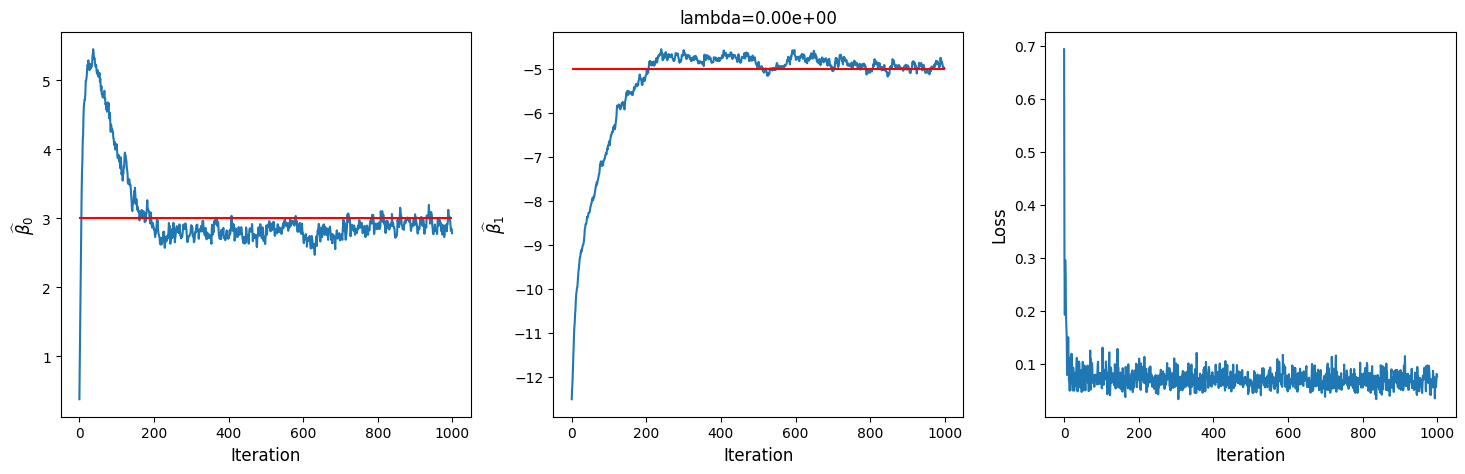

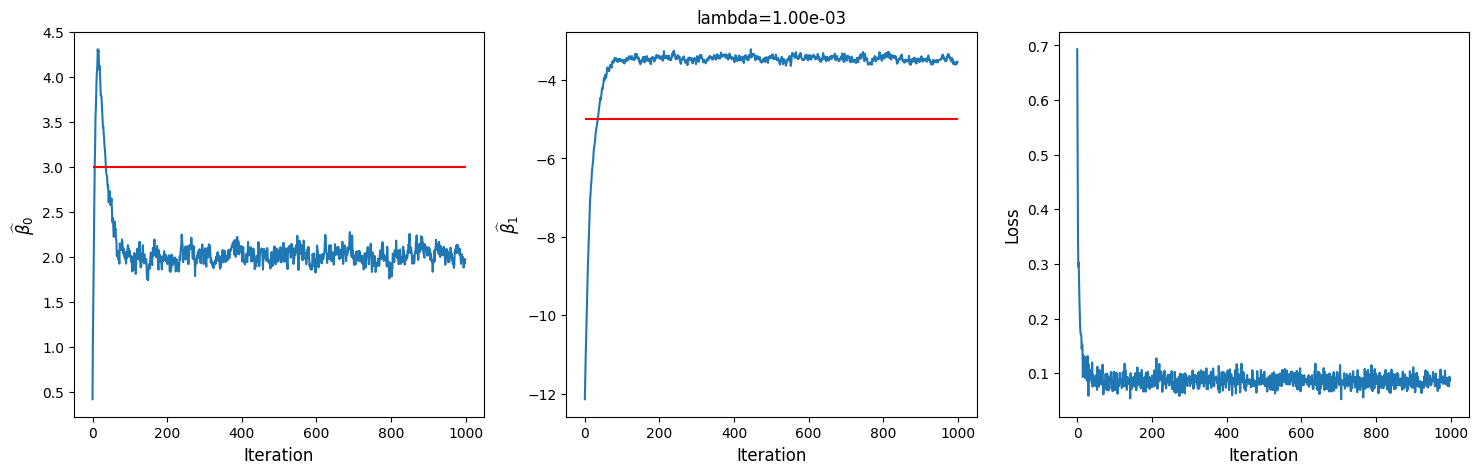

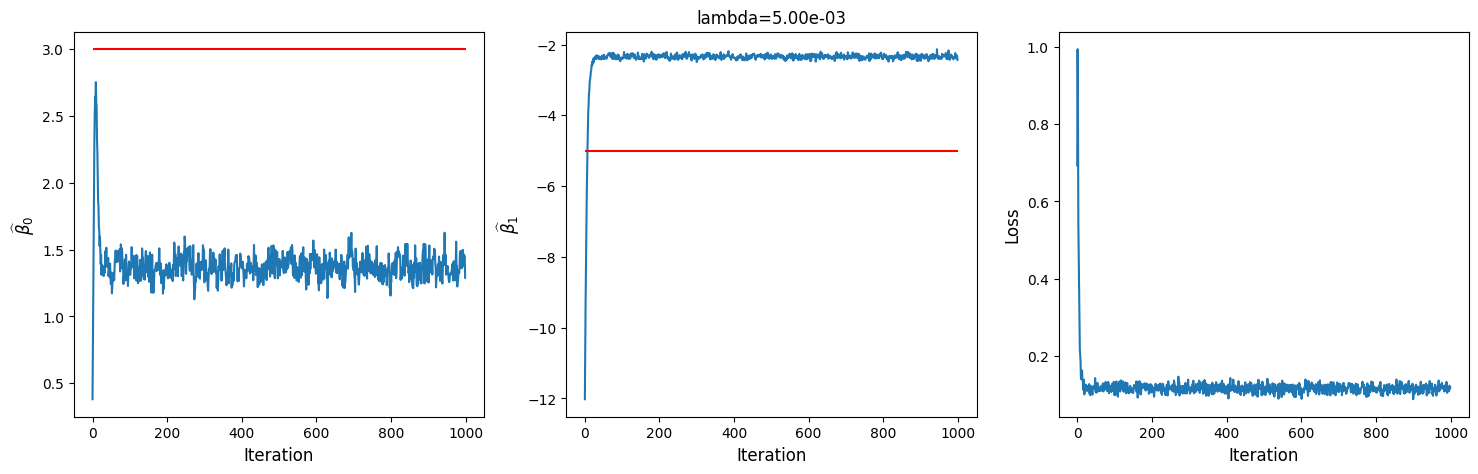

In [307]:
# run this cell, don't change it

for lamb in [0, .001, .005]:
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=500, lamb=lamb)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'lambda=%.2e' % lamb)

Comment on these results:

1. Describe what causes the differences in the plots across the three regularization levels.
1. Does one of the three runs give a better estimate than the others? Why or why not?


**[Put your answers in this markdown cell]**

(1) What causes the differences across the three regularization levels?

Regularization changes the optimization objective from the negative log-likelihood to a penalized loss:
$$
L(\beta_0,\beta_1)
=\frac{1}{n}\sum_{i=1}^n\Big[\log\!\big(1+e^{\beta_0+X_i\beta_1}\big)-Y_i(\beta_0+X_i\beta_1)\Big]
+\lambda \beta_1^2.
$$
Thus, different values of $\lambda$ lead to different minimizers and different gradient updates. As $\lambda$ increases, the L2 penalty exerts a stronger pull toward smaller $|\hat\beta_1|$, so $\hat\beta_1$ is shrunk toward $0$ (introducing bias). In mini-batch gradient descent the gradient is computed from a random subset, so it is noisy; stronger regularization typically damps the effect of this noise and can make the parameter trajectories appear smoother, whereas weaker regularization allows larger-magnitude coefficients and can show more variability across iterations.

(2) Does one of the runs give a better estimate than the others? Why or why not?

It depends on the criterion. If the goal is the estimation accuacy for the true data-generating values $(\beta_0,\beta_1)=(3,-5)$, then $\lambda=0$(or very small $\lambda$) is least biased in expectation, while larger $\lambda$ induces shrinkage bias (especially for $\beta_1$). If the goal is prediction/generalization, a moderate $\lambda$ can be preferable because it reduces variance and may lower test error.

I would say non of these outperform the others, Because this is a rather simple tast, so although larger $\lambda$ yields more shrinkage of $\hat\beta_1$, they all provide a good parameter accuracy and the result looks stable.

### 2.6 Batch size and stochastic gradient descent

Repeat 2.3 with different batch sizes, 1,10,100,1000. How do the plots change as we change batch size? Are the changes consistent with your expectation? Why or why not? Do you think we should use larger batch sizes or smaller ones? How do you reconcile the results with the prevalent use of mini-batch gradient descent rather than SGD and batch gradient descent?

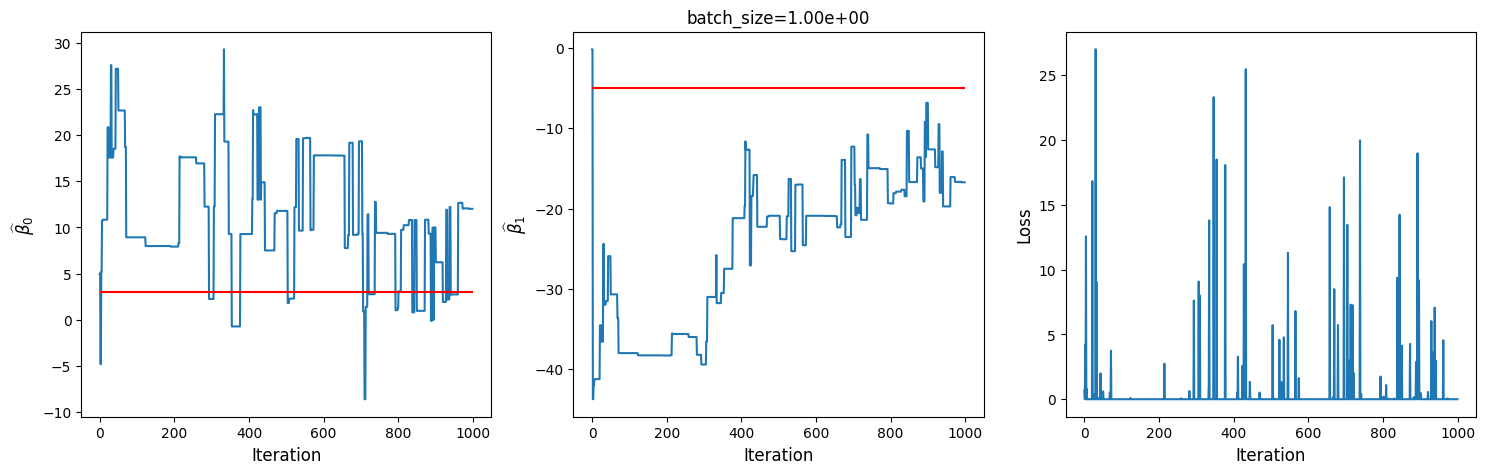

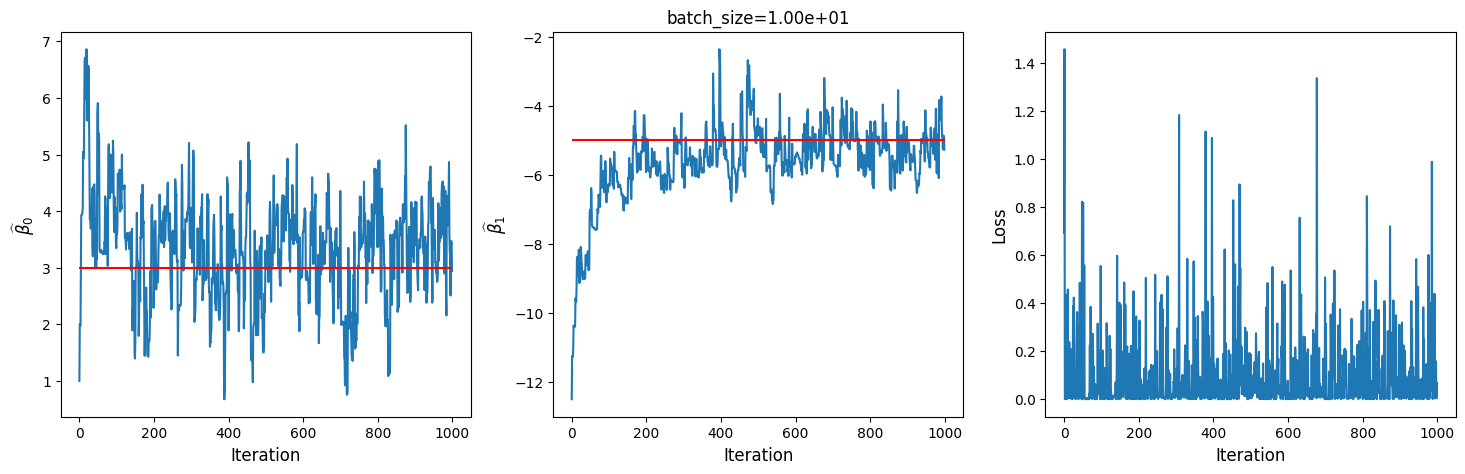

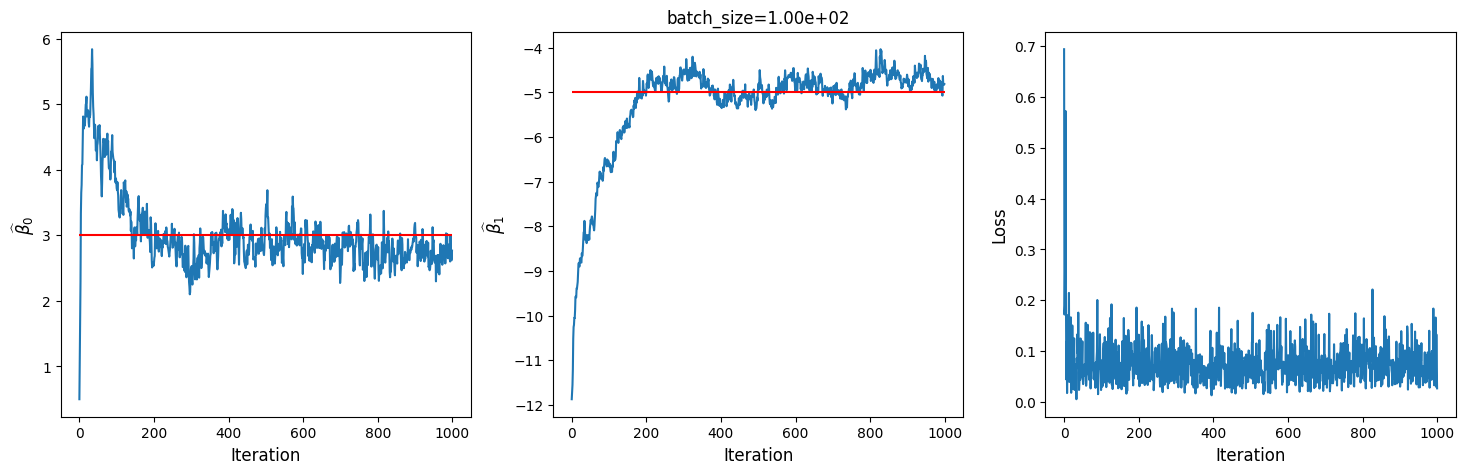

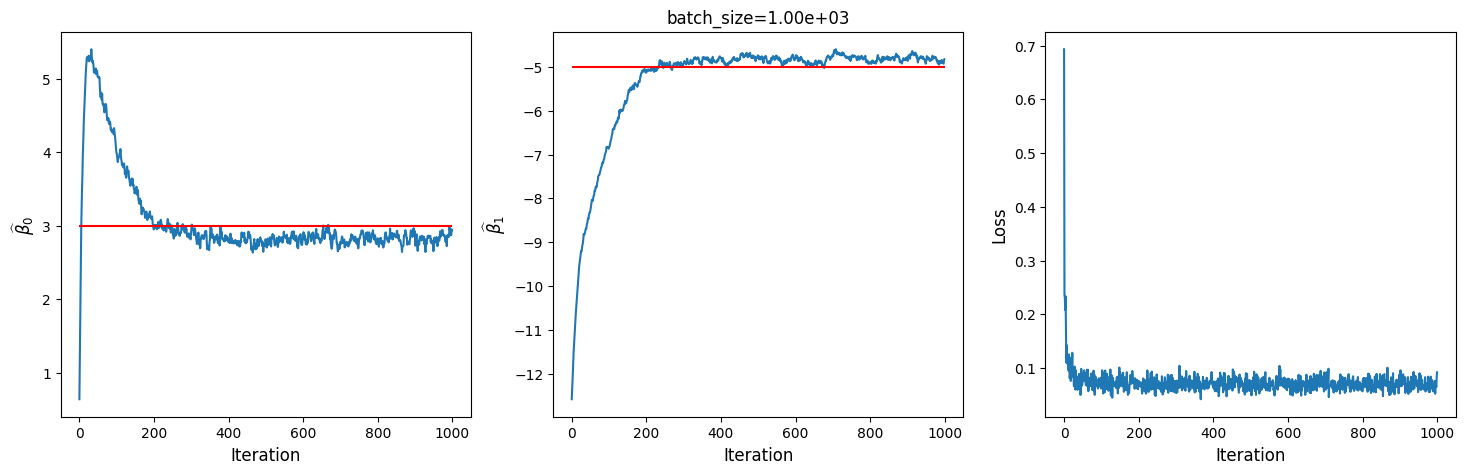

In [308]:
# run this cell, don't change it

for batch_size in [1, 10, 100, 1000]:
    iterations = int(10000/batch_size)
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=batch_size, lamb=0,iterations=1000)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'batch_size=%.2e' % batch_size)

Comment on these results:

1. Describe what causes the differences in the plots across the three batch sizes.
2. Does one of the three runs give a better estimate than the others? Why or why not?

**[Put your answers in this markdown cell]**

**Effect of batch size on the trajectories.**

In mini-batch gradient descent, at iteration $t$ we sample a batch $B_t$ of size $m$ and update

$$
(\beta_0,\beta_1)\leftarrow (\beta_0,\beta_1)-\eta\,\nabla L_{B_t}(\beta_0,\beta_1),
$$

where $\nabla L_{B_t}$ is the gradient computed using only the observations in $B_t$.

The key difference across batch sizes is the variance of this stochastic gradient:

smaller $m$ produces a noisier estimate of the full-data gradient, while larger $m$ produces a gradient closer to the true (full-batch) gradient.

**How the plots change as $m$ increases (e.g., $m=1,10,100,1000$).**

As $m$ increases, the $\widehat{\beta}_0$ and $\widehat{\beta}_1$ trajectories typically become smoother and the loss curve exhibits less jitter.

This matches the expectation that the stochastic gradient noise decreases with batch size (roughly like $1/m$), so parameter updates are less random.

Conversely, with very small batches (especially $m=1$), the paths can be highly oscillatory and may require a smaller step size $\eta$ to avoid instability.

**Should we use larger or smaller batch sizes?**

There is a tradeoff. Larger $m$ reduces gradient noise and can yield more stable, monotone-looking loss curves, but each iteration is more expensive.

Smaller $m$ gives cheaper iterations and often makes rapid initial progress, but introduces more variance in the updates and produces noisier trajectories.

**Why mini-batch GD is widely used (vs. SGD and full-batch GD).**

In practice, mini-batch gradient descent strikes a balance between the two extremes:

- Compared to SGD ($m=1$), using a mini-batch averages out some randomness in the gradient estimate, so the updates are less noisy and training is typically **more stable** (often allowing a larger step size $\eta$).
- Compared to full-batch GD ($m=n$), each update uses far fewer data points, so the cost per iteration is much smaller, which makes updates faster.

Because of this tradeoff, mini-batch GD often gives a good combination of **stable progress** and **computational efficiency**.


**What causes differences across batch sizes?**

The differences are mainly driven by stochastic gradient noise:
for batch size $m$, the mini-batch gradient $\nabla L_{B_t}$ is an unbiased but noisy estimate of the full gradient $\nabla L$, and its variability decreases as $m$ increases.

Therefore, smaller batches show more fluctuation in $(\widehat{\beta}_0,\widehat{\beta}_1)$ and in the loss, while larger batches look smoother.

**Does one of these run give a better estimate?**

If ``better'' means closer to the true parameters $(\beta_0,\beta_1)=(3,-5)$, larger batches tend to produce less noisy final estimates for a fixed number of iterations because updates are closer to full-batch gradient descent.

However, for a fixed computational budget, smaller or intermediate batch sizes may be preferable because they perform more updates per unit time and can reach the optimum quickly.



## Problem 3. Bias and Variance and Trees, Oh My! (20 points)


In this problem you will explore the bias-variance tradeoff for decision trees using a simple toy regression problem. We start by importing a few packages.


In [309]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline

The following cell defines and plots the data for this regression problem. The true regression function is `f`; the response `y` is `f` plus noise. The true function is -1 above the line `x1==x2` and 1 below the line. Just run this cell; do not modify it.

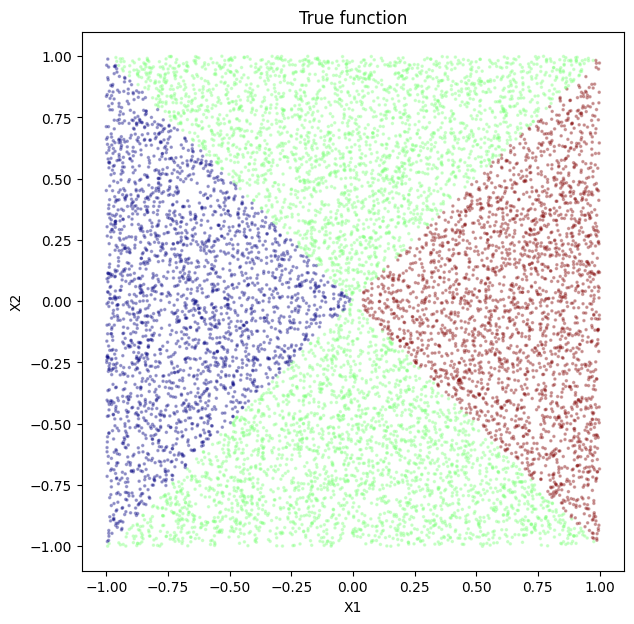

In [310]:
n = 10000
np.random.seed(265)

X = np.random.uniform(low=-1, high=1, size=2*n).reshape(n,2)
f = np.sign(X[:,0] - X[:,1]) + np.sign(X[:,0] + X[:,1])
y = f + np.random.normal(size=n)

fig = plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=f, alpha=.3, s=2.5, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
_ = plt.title('True function')

### 3.1 Build regressions trees with different depth

In this problem you are asked to build a sequence of regression trees using this data, to predict `y` from `x1` and `x2`, varying the tree depth.

* Vary the maximuim tree depth from 1 to 7
* Train each tree on a random set of 500 data points
* Test on the remaining 10000 - 500 data points
* Run 500 trials (train/test splits) for each depth.
* Plot the MSE as a function of the maximum tree depth

The cell below contains some starter code. You may modify this starter code in any way you wish. But be sure to *keep the lines at the end, which plots the mean squared error on the test data versus the depth.*

100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Text(0, 0.5, 'MSE')

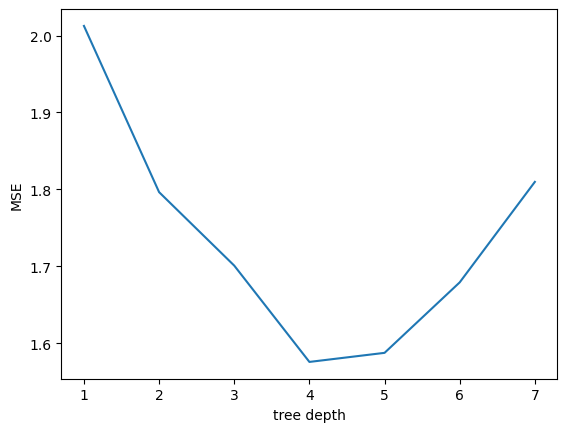

In [311]:
trials = 500
tree_depth = np.arange(1, 8)
test_mean_squared_error = np.zeros(len(tree_depth))

from tqdm import tqdm
for d in tqdm(tree_depth):
    rtree = DecisionTreeRegressor(max_depth=d)
    err = 0
    for trial in np.arange(trials):
      X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=500)
      rtree = rtree.fit(X_train, y_train)
      err += np.mean((rtree.predict(X_test)-y_test)**2)
    err = err/trials
    test_mean_squared_error[d-1] = err




fig = plt.figure()
plt.plot(tree_depth, test_mean_squared_error)
plt.xlabel('tree depth')
plt.ylabel('MSE')

### 3.2 What is the best size of tree?

(a) According to your plot above, what is the best tree depth to choose?

(b) If the regression trees were trained on 5000 data points, rather than 500, how would the choice of tree depth change? Would it increase or decrease? Explain why. Try to answer this question without running any code! If you run an experiment, comment on this in your answer.


[Your answer here in Markdown]

**(a)** From the plot with training size $500$, the test MSE is minimized at depth $d^\star \approx 4$, so the best tree depth to choose is $\mathbf{4}$. The test error decreases as depth increases up to about $4$, and then increases for deeper trees, consistent with the bias--variance tradeoff.

**(b)** When we increase the training set from $500$ to $5000$, the preferred depth increases. The reason is that tree algorithm is a 'greedy' algorithm, and deeper trees have lower bias but higher variance; using more training data reduces variance and makes overfitting less severe, so a more complex (deeper) tree can generalize better.

Equivalently, for each depth $d$ we are estimating the expected test error via repeated splits:
$$
\widehat{\mathrm{MSE}}(d)
=\frac{1}{T}\sum_{t=1}^{T}\left[\frac{1}{n_{\mathrm{test}}}\sum_{i\in \mathrm{test}_t}\big(\hat f_{d,t}(X_i)-Y_i\big)^2\right]
$$
When the training size increases, the fitted function $\hat f_{d,t}$ becomes less variable across trials, so larger $d$ is less prone to overfitting and can yield lower test MSE.


### 3.3 Estimate the squared bias and variance
Now estimate the squared bias and variance of the trees as a function of the maximum depth. This is possible in this case because you know the true function `f`, which was defined above. Use the same setup as above:

* Vary the maximuim tree depth from 1 to 7
* Train each tree on a random set of 500 data points
* Run 500 trials for each train/test split.

To estimate the squared bias and variance, evaluate each of the models on each of the $n=10,000$ data points. You can then estimate the squared bias and variance of the predictions $\hat y_i = \hat f(x_i)$ and take the average
over all the data points.

Hint: Consider using the fact that the variance of a random variable can be written as $\mbox{Var}(Z) = \mathbb{E}(Z^2) - \mathbb{E}(Z)^2$.  The cell below contains starter code based on this hint. You will need to use the true regression function `f` defined above as a numpy array.

You may modify this starter code in any way you wish. But be sure to *keep the lines at the end, which plots the squared bias and variance.*

In [312]:
rtree = DecisionTreeRegressor(max_depth=d)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=500)
rtree = rtree.fit(X_train, y_train)
E_yhat = np.zeros(n)
E_yhat +=rtree.predict(X)
E_yhat


array([ 0.02017173, -0.14363528,  2.29462944, ...,  1.4685641 ,
        0.98337842, -1.83426483])

100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


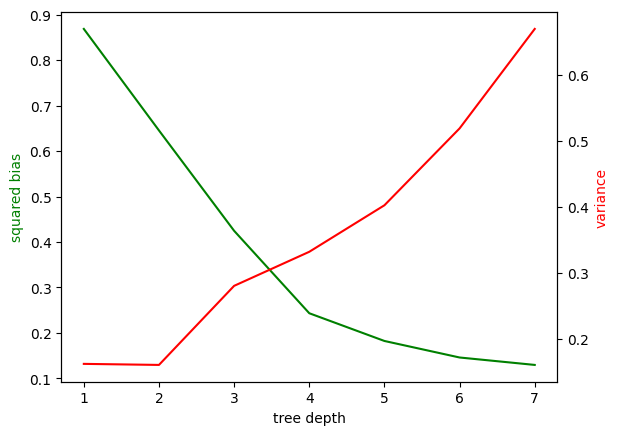

In [313]:
trials = 500
tree_depth = np.arange(1, 8)
bias_squared = []
variance = []

from tqdm import tqdm
for d in tqdm(tree_depth):
    rtree = DecisionTreeRegressor(max_depth=d)
    E_yhat = np.zeros(n)
    E_yhat_squared = np.zeros(n)
    for trial in np.arange(trials):
      X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=500)
      rtree = rtree.fit(X_train, y_train)
      pred = rtree.predict(X)
      E_yhat += pred
      E_yhat_squared += pred**2

    E_yhat /= trials
    E_yhat_squared /= trials

    # just run the following lines (or modify as needed)
    bias_squared.append(np.mean((E_yhat - f)**2))
    variance.append(np.mean(E_yhat_squared - E_yhat**2))


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(tree_depth, bias_squared, 'g-')
ax2.plot(tree_depth, variance, 'r-')
ax1.set_xlabel('tree depth')
ax1.set_ylabel('squared bias', color='g')
_ = ax2.set_ylabel('variance', color='r')

### 3.4 Do the bias and variance make sense?

(a) Explain why your plots of the squared bias and variance make sense, and are consistent with your plot of the MSE computed previously.

(b) What is the (approximate) value of the difference between the MSE and the sum of the squared bias and variance for this data set?


[Your answer here in markdown]
**3.4 Do the bias and variance make sense?**

**(a)** Yes. As the maximum tree depth increases, the regression tree becomes more flexible (higher model complexity). This reduces approximation error, so the squared bias decreases with depth. At the same time, deeper trees fit each particular training set more closely and become more sensitive to the sampled training data, so the variance of $\hat f(x)$ across different train/test splits increases.

This is also consistent with the test MSE curve. For each fixed $x$,
$$
y = f(x) + \varepsilon,\qquad \mathbb{E}[\varepsilon]=0,\qquad \mathrm{Var}(\varepsilon)=\sigma^2,
$$
and the prediction error decomposes as
$$
\mathbb{E}\!\left[\bigl(Y-\widehat f(X)\bigr)^2\right]
=
\left(\mathbb{E}\!\left[\widehat f(X)\right]-f(X)\right)^2
+
\mathrm{Var}\!\left(\widehat f(X)\right)
+
\sigma^2.
$$

So as depth increases, squared bias decreases and variance increases, and the MSE is minimized at an intermediate depth where the tradeoff is best—matching the observed U-shaped MSE trend.

**(b)** The difference between the MSE and the sum of squared bias and variance should be approximately the irreducible noise variance:
$$
\text{MSE} - \left(\text{squared bias}+\text{variance}\right) \approx \sigma^2.
$$
Here $\varepsilon\sim N(0,1)$, so $\sigma^2\approx 1$. Therefore the difference is approximately **1**.
